In [45]:
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Core machine learning libraries from scikit-learn
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import (BaggingRegressor, AdaBoostRegressor, RandomForestRegressor,  
                              GradientBoostingRegressor, StackingRegressor)
from sklearn.model_selection import (StratifiedKFold, cross_validate, train_test_split,
                                     KFold, cross_val_score, GridSearchCV)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# Extended machine learning libraries
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Suppress potential warnings
import warnings
warnings.filterwarnings("ignore")

# Visualization settings
plt.rcParams['figure.dpi'] = 100


<a class="anchor" id="head-1"></a>
### Data Pre-processing 

<a id="head-1-1"></a>
### Getting the Data

In [46]:
# Load the CSV file into a DataFrame
full_df = pd.read_csv('converted_data.csv')

# Get the number of rows and columns in the DataFrame
rows, columns = full_df.shape

# Print the dimensions of the DataFrame
print(f'This data contains {rows} rows and {columns} columns.')

This data contains 41929 rows and 48 columns.


In [47]:
import pandas as pd

# Load the CSV file into a DataFrame
full_df = pd.read_csv('converted_data.csv')

# List of columns to be removed from the DataFrame
columns_to_drop = ['country', 'currency', 'daysOnZillow', 'homeStatus', 'homeStatusForHDP', 'imgSrc',
                   'isFeatured', 'isNonOwnerOccupied', 'isPreforeclosureAuction', 'isPremierBuilder',
                   'isShowcaseListing', 'isUnmappable', 'isZillowOwned', 'listing_sub_type',
                   'providerListingID', 'openHouse', 'open_house_info', 'videoCount', 'priceReduction',
                   'isRentalWithBasePrice', 'comingSoonOnMarketDate', 'priceForHDP', 'shouldHighlight',
                   'zpid', 'rentZestimate', 'zestimate', 'unit', 'datePriceChanged',
                   'priceChange', 'group_type', 'priceSuffix', 'timeOnZillow', 'streetAddress', 
                   'taxAssessedValue', 'city', 'newConstructionType', 'lotAreaUnit', 'lotAreaValue', 'zipcode']

# Drop the specified columns
full_df.drop(columns=columns_to_drop, inplace=True)

# Print the count of non-null values in each column
print(full_df.count())


bathrooms       39753
bedrooms        39579
homeType        41929
latitude        41087
livingArea      39256
longitude       41087
price           36841
state           41929
lotArea_sqft    36419
dtype: int64


Potentially Useful Columns:
bathrooms: Number of bathrooms.
bedrooms: Number of bedrooms.
city: City in which the house is located.
country: Country of the house.
latitude and longitude: Geographic coordinates.
livingArea: Size of the house in square feet.
lotAreaValue and lotAreaUnit: Size of the lot.
price: Sale price of the house.
state: State in which the house is located.
streetAddress: Specific address of the property.
zipcode: Postal code of the property.
homeType: Type of home (e.g., single-family, condo).
taxAssessedValue: Value assessed for tax purposes.
newConstructionType: Indicates if the property is a new construction.

Columns to Consider Removing:
currency, daysOnZillow, homeStatus, homeStatusForHDP, imgSrc, isFeatured: These are mostly metadata or status indicators that do not necessarily reflect the intrinsic value of the property.

isNonOwnerOccupied, isPreforeclosureAuction, isPremierBuilder, isShowcaseListing, isUnmappable, isZillowOwned: Status indicators or features that might not be available at prediction time or universally for all properties.

listing_sub_type, providerListingID, openHouse, open_house_info, videoCount, priceReduction, isRentalWithBasePrice, comingSoonOnMarketDate: Again, mostly metadata, marketing status, or temporary states of the listing that don’t typically affect long-term value.

If the two variables provide similar information but zip codes offer more detail and don't introduce excessive complexity or overfitting issues in your model, you might consider dropping the city column and keeping zipcode.

Data Exploration and Analysis

In [48]:
#The shape of our data
rows, columns = full_df.shape
print('This data contains {} rows and {} columns'.\
      format(rows, columns))

This data contains 41929 rows and 9 columns


In [50]:
#  Identify Duplicates
duplicate_rows = full_df[full_df.duplicated()]

# Analyze Duplicate Patterns
duplicate_count = len(duplicate_rows) 
duplicate_percentage = (duplicate_count / len(full_df)) * 100

print("Number of duplicate rows:", duplicate_count)
print("Percentage of duplicate rows:", duplicate_percentage)

Number of duplicate rows: 3986
Percentage of duplicate rows: 9.506546781463904


In [5]:
full_df.head()

,bathrooms,bedrooms,homeType,latitude,livingArea,longitude,price,state,lotArea_sqft
0,2.0,3.0,SINGLE_FAMILY,33.399773,1835.0,-111.664310,399900.0,AZ,6852.000
1,2.0,3.0,MANUFACTURED,32.959890,1569.0,-111.323830,255000.0,AZ,64699.668
2,2.0,3.0,SINGLE_FAMILY,34.197773,2260.0,-109.907320,649000.0,AZ,100623.600
3,NaN,NaN,LOT,33.746326,NaN,-112.534320,325000.0,AZ,383328.000
4,4.0,4.0,SINGLE_FAMILY,33.505280,3175.0,-112.481155,1199000.0,AZ,43603.560


In [6]:
# Display the summary information about the DataFrame
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41929 entries, 0 to 41928
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     39753 non-null  float64
 1   bedrooms      39579 non-null  float64
 2   homeType      41929 non-null  object 
 3   latitude      41087 non-null  float64
 4   livingArea    39256 non-null  float64
 5   longitude     41087 non-null  float64
 6   price         36841 non-null  float64
 7   state         41929 non-null  object 
 8   lotArea_sqft  36419 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.9+ MB


In [7]:
#finding the unique values in each column (type object)
for col in full_df.select_dtypes('O').columns:
    print('We have {} unique values in {} column : {}'.format(len(full_df[col].unique()),col,full_df[col].unique()))
    print('__'*30)

We have 12 unique values in homeType column : ['SINGLE_FAMILY' 'MANUFACTURED' 'LOT' 'APARTMENT' 'TOWNHOUSE'
 'MULTI_FAMILY' 'CONDO' 'CONDO_TOWNHOME_ROWHOME_COOP' 'FARM' 'COOP'
 'DUPLEX_TRIPLEX' 'OTHER']
____________________________________________________________
We have 19 unique values in state column : ['AZ' 'CA' 'CO' 'CT' 'DE' 'NY' 'OH' 'IN' 'FL' 'TX' 'PA' 'NC' 'GA' 'MA'
 'LA' 'NH' 'NJ' 'VA' 'WA']
____________________________________________________________


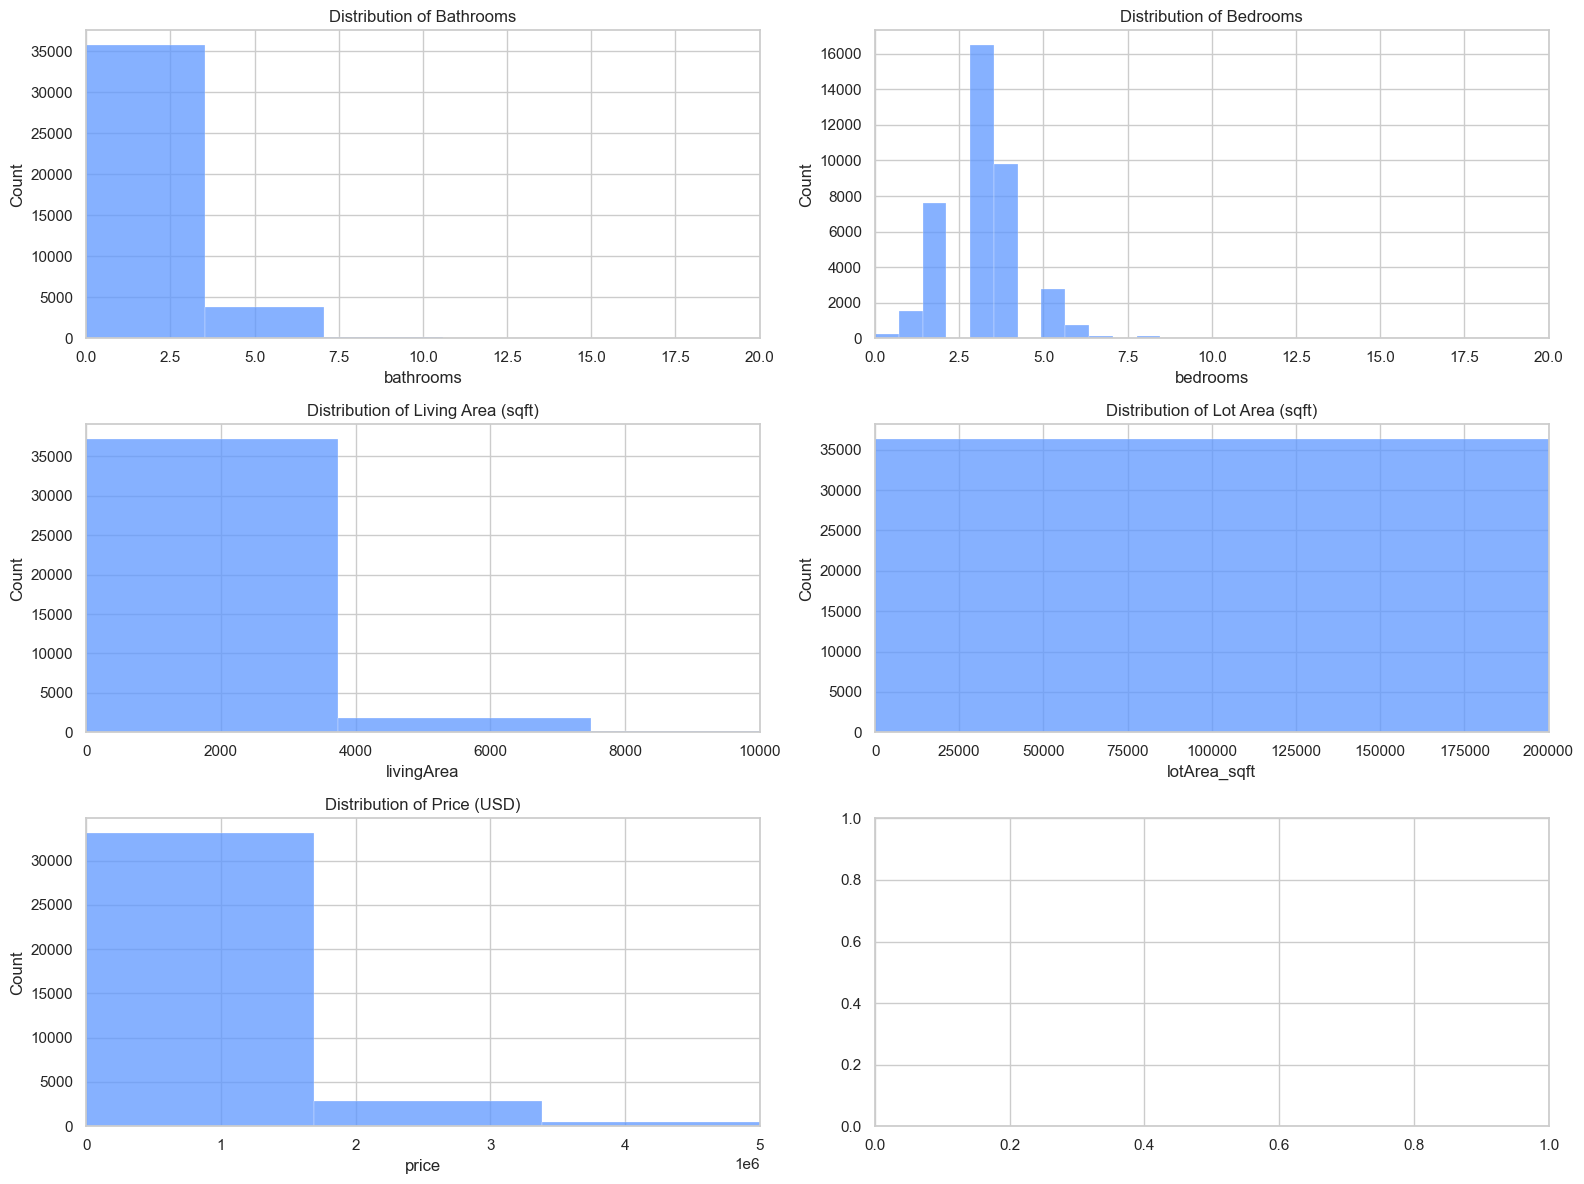

In [8]:

# Setting up the aesthetics for plots
sns.set(style="whitegrid")

# Creating a figure to hold the visualizations
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))

# Helper function to calculate number of bins using the square-root choice
def calculate_bins(data):
    return int(np.sqrt(len(data)))

# Plotting distributions of numerical variables with dynamic bin sizes
feature_list = ['bathrooms', 'bedrooms', 'livingArea', 'lotArea_sqft', 'price']
limits = [(0, 20), (0, 20), (0, 10000), (0, 200000), (0, 5000000)]
titles = ['Bathrooms', 'Bedrooms', 'Living Area (sqft)', 'Lot Area (sqft)', 'Price (USD)']

for ax, feature, limit, title in zip(axes.flat, feature_list, limits, titles):
    bins = calculate_bins(full_df[feature])
    sns.histplot(full_df[feature], bins=bins, ax=ax, color='#5d97ff')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlim(limit)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


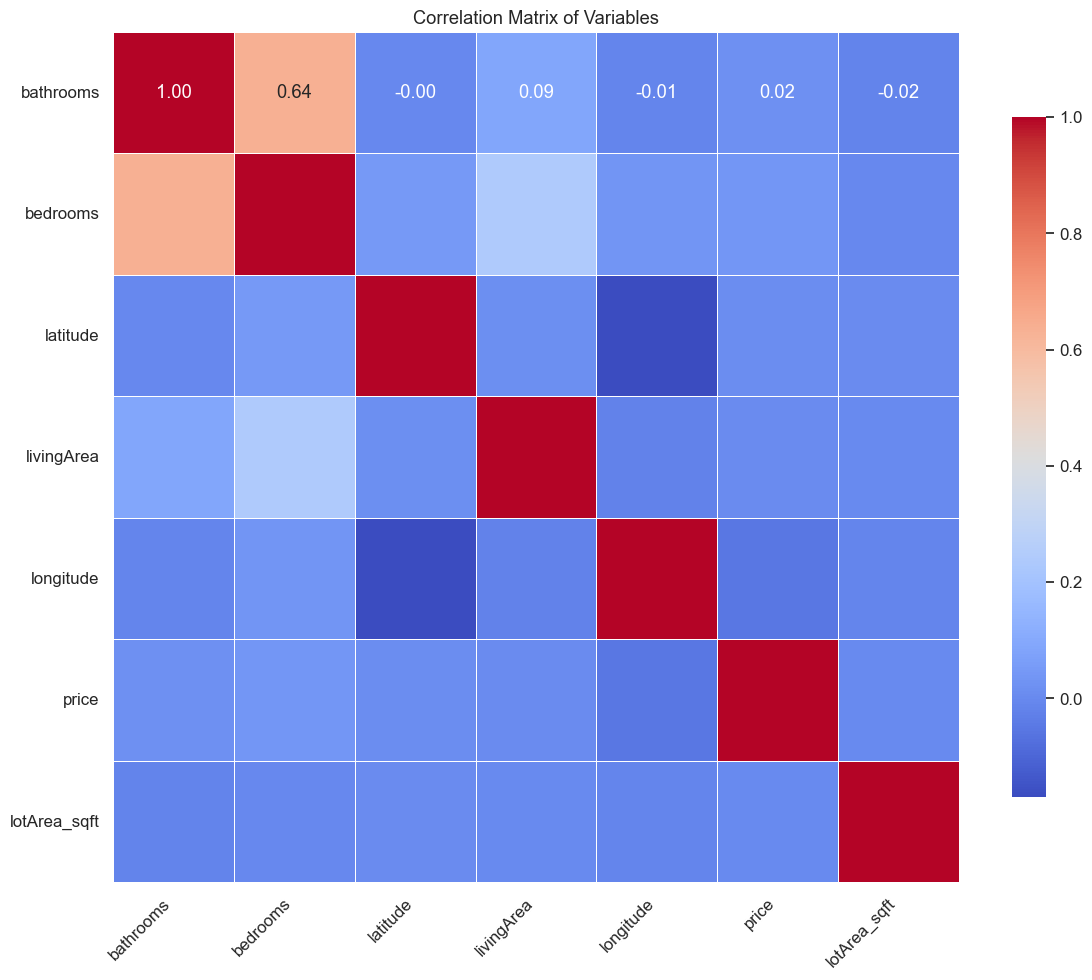

In [9]:
# Select only numerical columns for correlation matrix
numerical_data = full_df.select_dtypes(include=[np.number])

# Compute the correlation matrix for numerical columns only
correlation_matrix = numerical_data.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))  # Adjust the size of the figure
sns.set(font_scale=1.1)  # Increase font size for readability
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')  # Rotate x labels for better fit
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)  # Adjust y labels rotation if necessary
plt.title('Correlation Matrix of Variables')
plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

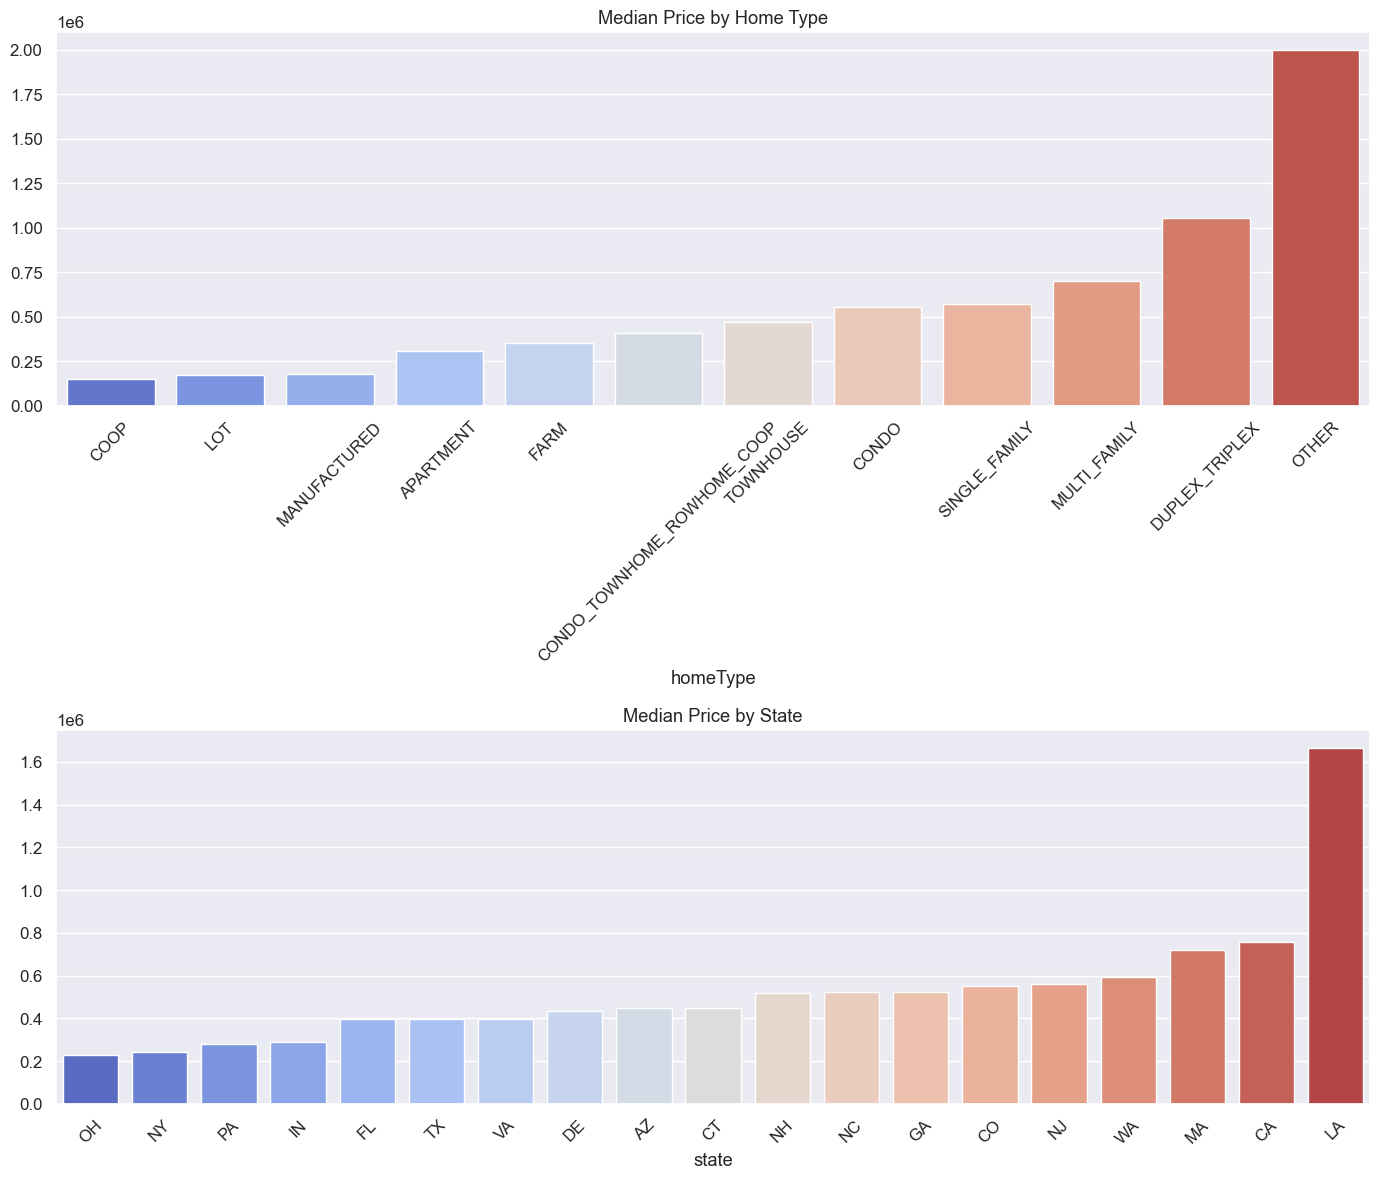

In [10]:
# Grouping data by 'homeType' and 'state' to find the median prices
median_price_by_homeType = full_df.groupby('homeType')['price'].median().sort_values()
median_price_by_state = full_df.groupby('state')['price'].median().sort_values()

# Creating visualizations for median price by homeType and state
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

sns.barplot(x=median_price_by_homeType.index, y=median_price_by_homeType.values, ax=axes[0], palette='coolwarm')
axes[0].set_title('Median Price by Home Type')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=median_price_by_state.index, y=median_price_by_state.values, ax=axes[1], palette='coolwarm')
axes[1].set_title('Median Price by State')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

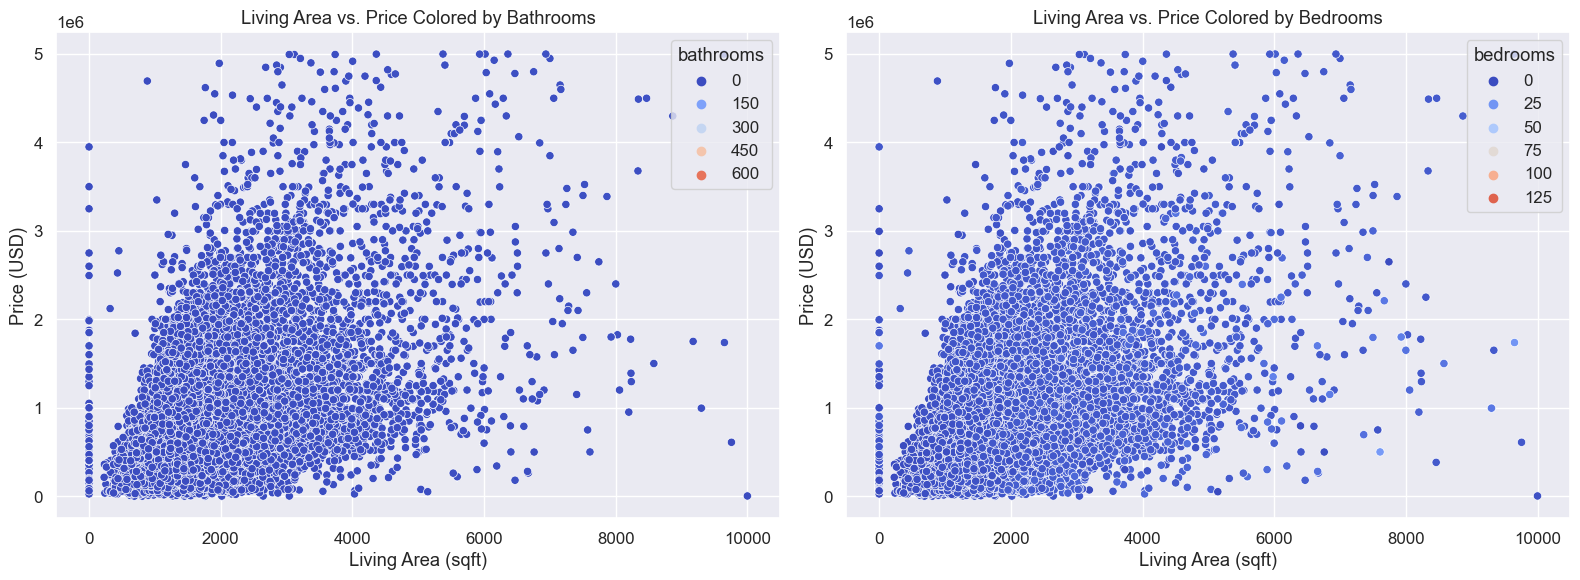

In [11]:
# Filtering out extreme outliers for clear visualization
filtered_data = full_df[(full_df['livingArea'] <= 10000) & (full_df['price'] <= 5000000)]

# Creating scatter plots for interaction effects
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Living Area vs Price colored by number of Bathrooms
sns.scatterplot(data=filtered_data, x='livingArea', y='price', hue='bathrooms', palette='coolwarm', ax=axes[0])
axes[0].set_title('Living Area vs. Price Colored by Bathrooms')
axes[0].set_xlabel('Living Area (sqft)')
axes[0].set_ylabel('Price (USD)')

# Plot 2: Living Area vs Price colored by number of Bedrooms
sns.scatterplot(data=filtered_data, x='livingArea', y='price', hue='bedrooms', palette='coolwarm', ax=axes[1])
axes[1].set_title('Living Area vs. Price Colored by Bedrooms')
axes[1].set_xlabel('Living Area (sqft)')
axes[1].set_ylabel('Price (USD)')

plt.tight_layout()
plt.show()

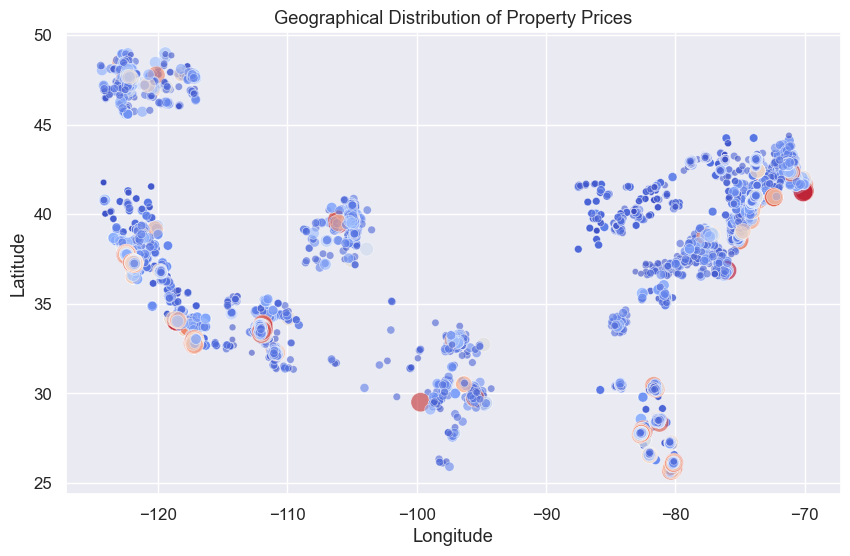

In [12]:
# Creating a geographical scatter plot of property prices
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x='longitude', y='latitude', size='price', hue='price',
                sizes=(20, 200), palette='coolwarm', legend=None, alpha=0.6)
plt.title('Geographical Distribution of Property Prices')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


### Correlation with Price

In [14]:
numerical_cols = full_df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numerical_cols.corr()

# Extract and sort the correlations relative to 'price', ignoring the first instance (price with itself)
sorted_corr = corr['price'].sort_values(ascending=False)[1:15]

# Convert to DataFrame and apply styling
sorted_corr_frame = sorted_corr.to_frame()  # Converting Series to DataFrame for styling
styled_corr = sorted_corr_frame.style.background_gradient(axis=1, cmap=sns.light_palette('green', as_cmap=True))

# Display styled DataFrame
styled_corr

,price
bedrooms,0.037331
bathrooms,0.020916
livingArea,0.004308
lotArea_sqft,0.001669


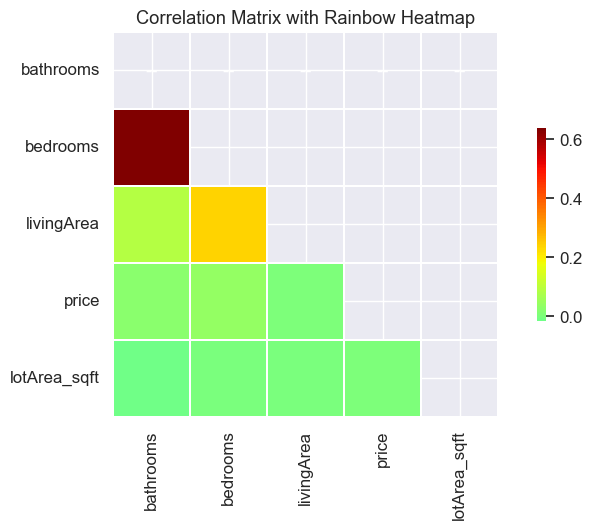

In [15]:
# Compute the correlation matrix
corr = numerical_cols.corr()

# Apply a mask to the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap using a rainbow-like colormap
plt.figure(figsize=(10,5))
sns.heatmap(corr, mask=mask, cmap='jet', annot=True, center=0,
            square=True, cbar_kws={"shrink": .5, "orientation": "vertical"}, linewidths=.02)
plt.title('Correlation Matrix with Rainbow Heatmap')
plt.show()

In [16]:
### before imputing and cleaning

### Before imputing and cleaning - Outliers Detection

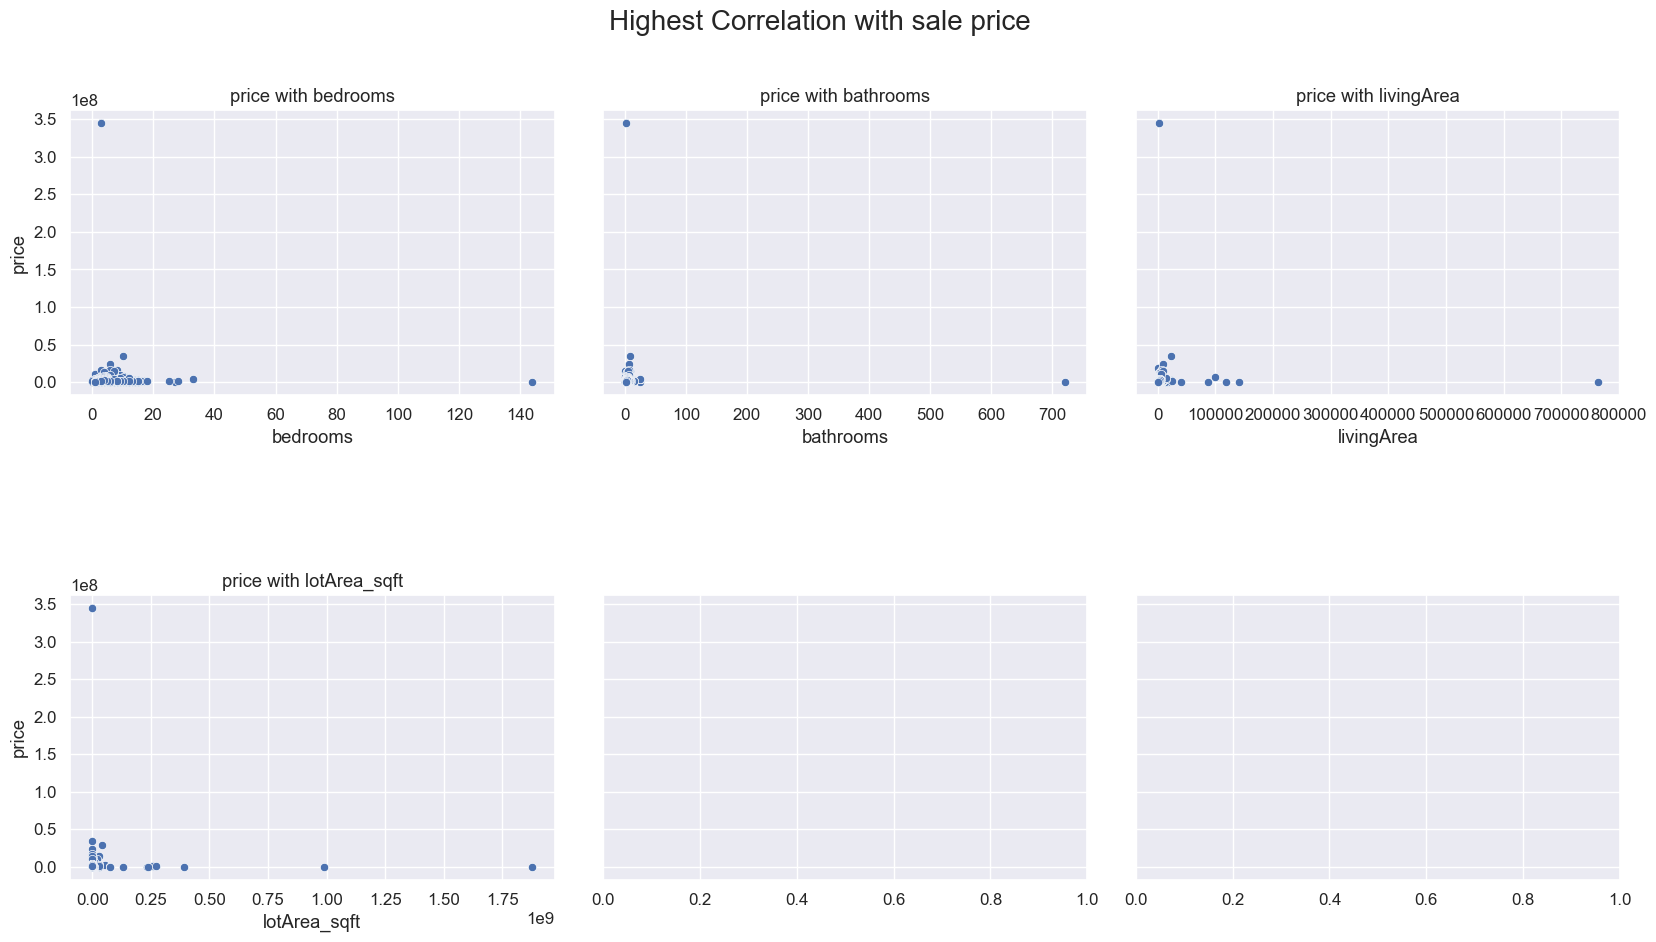

In [17]:
#Visualize columns have corr with SalePrice

high_corr = corr['price'].sort_values(ascending=False)[1:][:13].index.tolist()

fig, axes = plt.subplots(2,3, figsize=(20, 10), sharey=True);
plt.subplots_adjust(hspace = 0.7, wspace=0.1)
fig.suptitle('Highest Correlation with sale price', fontsize=20)

for i,col in zip(range(12),high_corr):
    sns.scatterplot(y=full_df['price'], x=full_df[col],ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title('price with '+col)

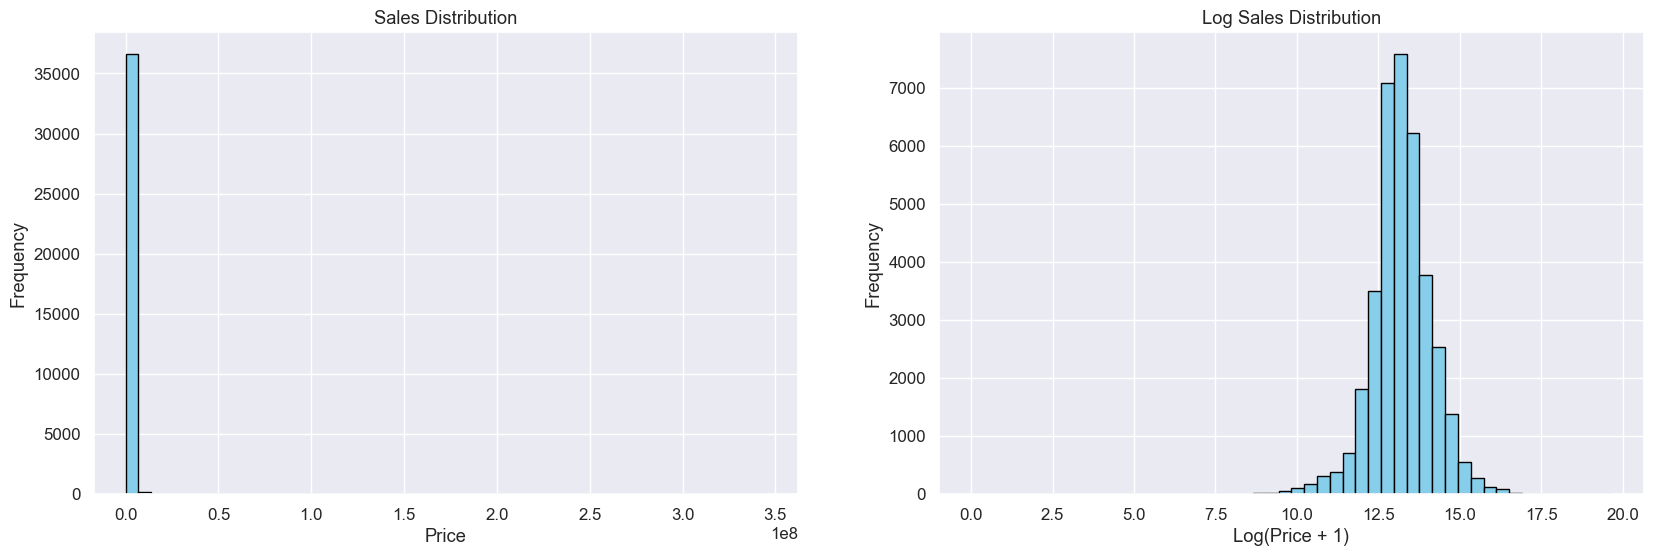

In [19]:
fig, axes = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)

# Histogram of the sales price
full_df['price'].hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Sales Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Histogram of the log-transformed sales price
np.log1p(full_df['price']).hist(ax=axes[1], bins=50, color='skyblue', edgecolor='black')
axes[1].set_title('Log Sales Distribution')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')

plt.show();

><b><li>Utilizing Logarithms: Applying logarithmic transformations can lead to a more normal distribution, which is advantageous for various analytical tasks including outlier detection.<br>
><b><li>Distribution Characteristics: The data exhibits a right-skewed distribution, with the majority of sales prices falling between $0 and $350,000




<a id="head-1-3-2"></a>
### Handling  Null values

In [20]:
# Calculate the percentage of null values for each column
null_percentages = (full_df.isnull().sum() / len(full_df) * 100).sort_values(ascending=False)

# Convert to DataFrame and rename the column for clarity
null_df = null_percentages.to_frame().rename(columns={0: 'Null values percentage'})

# Select the top 15 columns with the highest percentage of null values
top_nulls = null_df.head(15)

# Display the DataFrame
top_nulls

,Null values percentage
lotArea_sqft,13.141263
price,12.134799
livingArea,6.375063
bedrooms,5.604713
bathrooms,5.189725
homeType,0.000000
state,0.000000


### Visulizing the null values in each columns

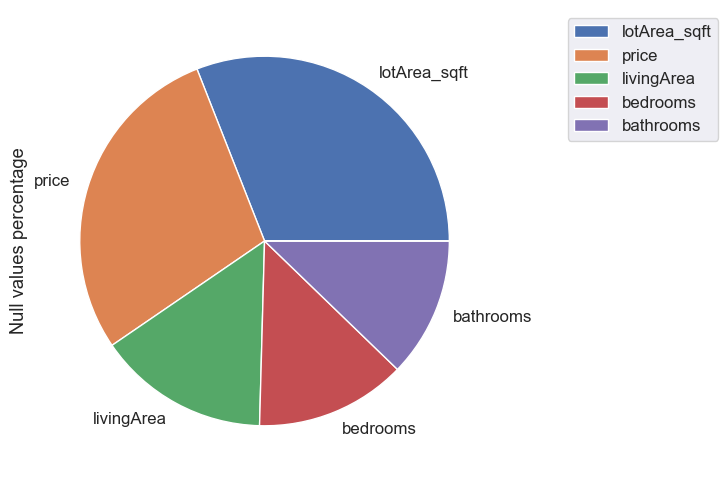

In [21]:
#Pie plot for the percentage values

(
    null_df.
    plot(kind='pie', x='index', y='Null values percentage', figsize=(20, 6)).
    legend(loc='best', bbox_to_anchor=(1.5, 1))
);

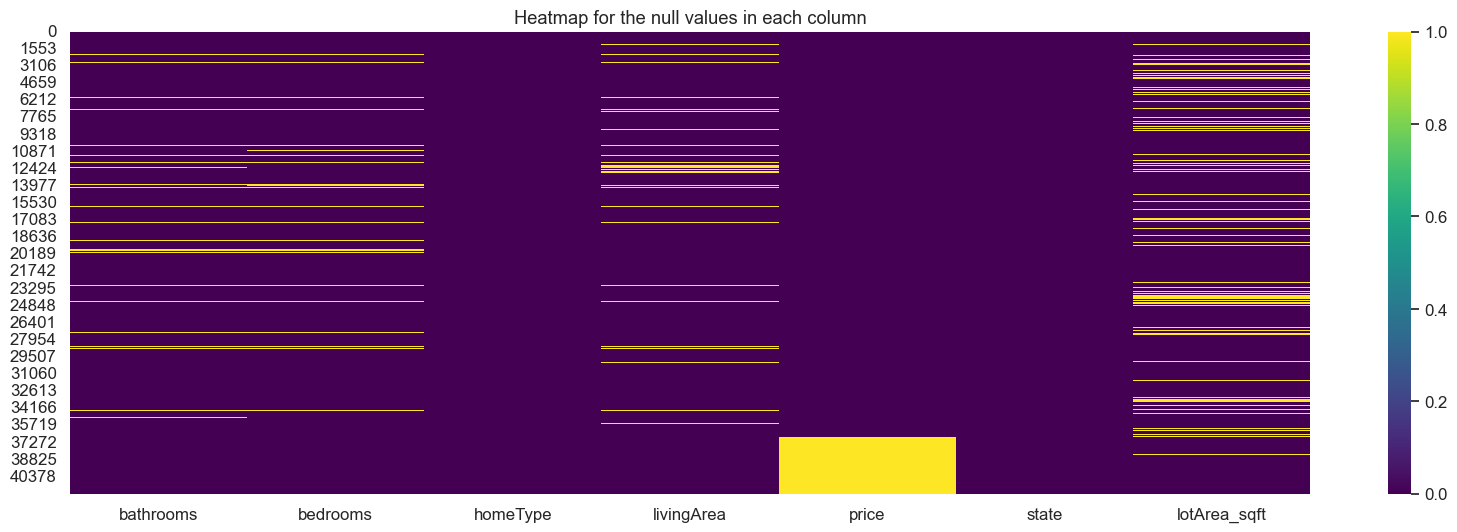

In [22]:
#Heatmap for the null values

plt.figure(figsize=(20,6))
plt.title('Heatmap for the null values in each column')
sns.heatmap(full_df.isnull(),cmap='viridis');

In [23]:
#DROP ROW IF ALL THESE ARE 0 IN ROW -> ['price', 'livingArea', 'bedrooms', 'bathrooms']

# Create a Boolean DataFrame where True indicates a value is either 0 or NaN
conditions = (full_df[['price', 'livingArea', 'bedrooms', 'bathrooms']] == 0) | full_df[['price', 'livingArea', 'bedrooms', 'bathrooms']].isna()

# Check if all specified columns in a row are True (i.e., all are 0 or NaN)
rows_to_drop = conditions.all(axis=1)

# Drop these rows from the DataFrame
filtered_df = full_df[~rows_to_drop]

# Display the resulting DataFrame to verify the rows have been dropped correctly
print("Original DataFrame shape:", full_df.shape)
print("Filtered DataFrame shape:", filtered_df.shape)

Original DataFrame shape: (41929, 7)
Filtered DataFrame shape: (41743, 7)


In [24]:
'''# Calculate the 10th and 90th percentiles of the 'price' column
price_10th = full_df['price'].quantile(0.0001)
price_90th = full_df['price'].quantile(0.9999)

# Filter the DataFrame to keep only rows where 'price' is between these percentiles
filtered_df = full_df[(full_df['price'] >= price_10th) & (full_df['price'] <= price_90th)]'''

"# Calculate the 10th and 90th percentiles of the 'price' column\nprice_10th = full_df['price'].quantile(0.0001)\nprice_90th = full_df['price'].quantile(0.9999)\n\n# Filter the DataFrame to keep only rows where 'price' is between these percentiles\nfiltered_df = full_df[(full_df['price'] >= price_10th) & (full_df['price'] <= price_90th)]"

In [25]:
#full_df = filtered_df

## Imputing missing values

In [26]:
# Replace blanks with NaN to handle them uniformly with null values
full_df.replace('', pd.NA, inplace=True)

# Impute 'lotArea_sqft', 'price', and 'livingArea' with median where values are 0 or NaN
for column in ['lotArea_sqft', 'price', 'livingArea']:
    median_value = full_df[column].median(skipna=True)  # Ensure to skip NaN in median calculation
    full_df[column] = full_df[column].replace(0, pd.NA).fillna(median_value)

# Impute 'bedrooms' and 'bathrooms' with mode where values are 0 or NaN
for column in ['bedrooms', 'bathrooms']:
    mode_value = full_df[column].mode(dropna=True)[0]  # Ensure to drop NaN in mode calculation
    full_df[column] = full_df[column].replace(0, pd.NA).fillna(mode_value)

# Now, full_df should have no missing, zero, or blank entries in the specified columns.

# Check for remaining missing values
remaining_nulls = full_df.isnull().sum()
print(remaining_nulls)

bathrooms       0
bedrooms        0
homeType        0
livingArea      0
price           0
state           0
lotArea_sqft    0
dtype: int64


In [27]:
# Check for the maximum number of null values in any column
max_nulls = full_df.isnull().sum().max()

# Print the result
print("Maximum number of null values in any column:", max_nulls)

Maximum number of null values in any column: 0


In [28]:
print('Categorical columns      Unique values count\n')
for col in ['homeType', 'state']:
    unique_count = len(full_df[col].unique())
    print(f"{col:20} {'-' * (10 - len(col))} > {unique_count}")

Categorical columns      Unique values count

homeType             -- > 12
state                ----- > 19


In [29]:
high_corr = corr['price'].sort_values(ascending=False)[1:14].index.tolist()

# Function to filter each column between its 1st and 99th percentiles
def filter_percentiles(df, columns):
    for col in columns:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Applying the filter to the 'price' column and other highly correlated columns
filtered_df = filter_percentiles(full_df, ['price'] + high_corr)
full_df=filtered_df



In [30]:
#AFTER REMOVING EXTREME OUTLIERS AND IMPUTING NULL VALUES AND MISSING DATA

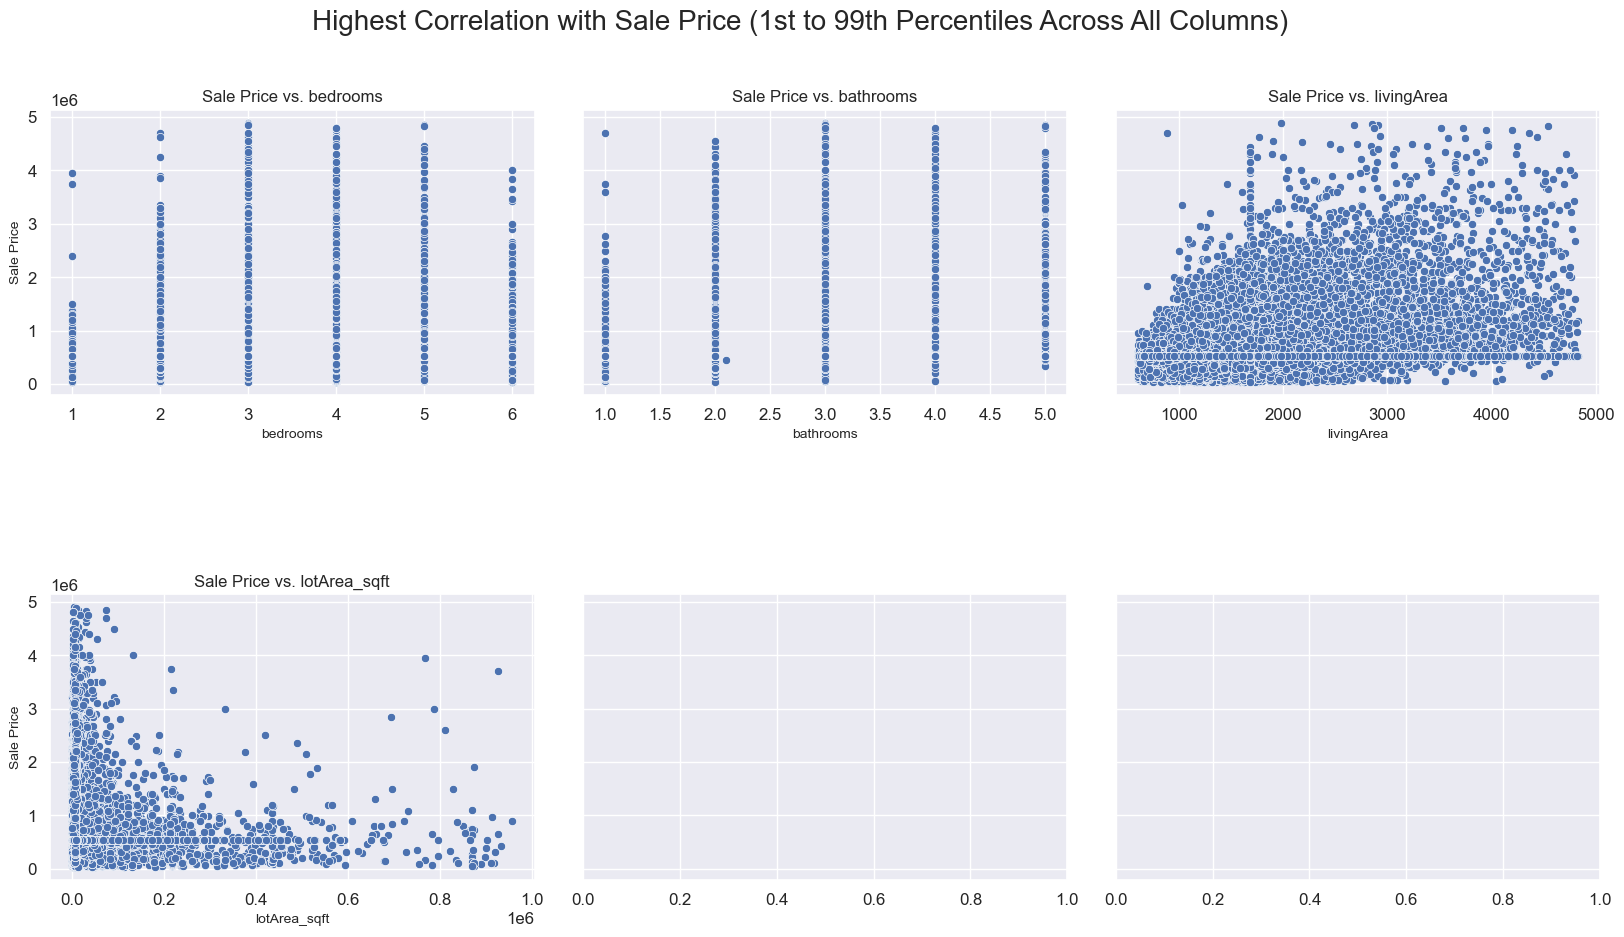

In [31]:
# Creating subplots for scatter plots
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
plt.subplots_adjust(hspace=0.7, wspace=0.1)
fig.suptitle('Highest Correlation with Sale Price (1st to 99th Percentiles Across All Columns)', fontsize=20)

# Plotting scatter plots for each high correlation variable against 'price'
for i, col in enumerate(high_corr):
    sns.scatterplot(x=filtered_df[col], y=filtered_df['price'], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Sale Price vs. {col}', fontsize=12)
    axes[i//3, i%3].set_xlabel(col, fontsize=10)
    axes[i//3, i%3].set_ylabel('Sale Price', fontsize=10)

plt.show()

In [32]:
rows, cols = full_df.shape
print('Our new cleaned data has {} rows and {} columns'.format(rows, cols))

Our new cleaned data has 38888 rows and 7 columns


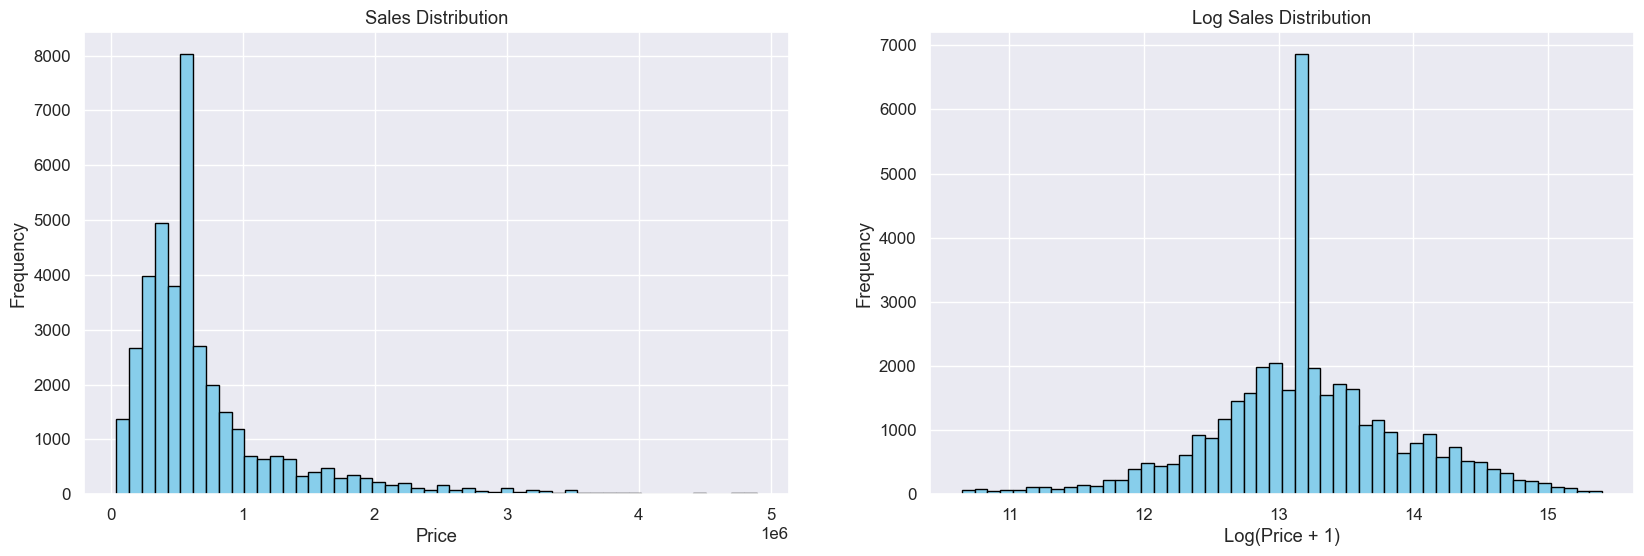

In [33]:
fig, axes = plt.subplots(figsize=(20, 6), nrows=1, ncols=2)

# Histogram of the sales price
full_df['price'].hist(ax=axes[0], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Sales Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Histogram of the log-transformed sales price
np.log1p(full_df['price']).hist(ax=axes[1], bins=50, color='skyblue', edgecolor='black')
axes[1].set_title('Log Sales Distribution')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')

plt.show();

<a id="head-1-4"></a>
### Prepare the data for ML

In [34]:
cat_cols=['homeType','state']
# Check if each column in cat_cols exists in full_df to prevent KeyErrors
existing_cat_cols = [col for col in cat_cols if col in full_df.columns]

# Convert all categorical columns to numeric values using LabelEncoder
for col in existing_cat_cols:
    lbl = LabelEncoder()
    # Handling columns that contain NaN by converting them to string type
    # LabelEncoder does not handle NaN values directly
    full_df[col] = lbl.fit_transform(full_df[col].astype(str))

print("Categorical columns encoded:", existing_cat_cols)

Categorical columns encoded: ['homeType', 'state']


In [35]:
full_df.head()

,bathrooms,bedrooms,homeType,livingArea,price,state,lotArea_sqft
0,2.0,3.0,10,1835.0,399900.0,0,6852.000
1,2.0,3.0,7,1569.0,255000.0,0,64699.668
2,2.0,3.0,10,2260.0,649000.0,0,100623.600
3,2.0,3.0,6,1686.0,325000.0,0,383328.000
4,4.0,4.0,10,3175.0,1199000.0,0,43603.560


<a id="head-1-5"></a>
### Skewness

In [36]:
# List of numeric columns to evaluate skewness
num_cols = ['bathrooms', 'bedrooms', 'livingArea', 'price', 'lotArea_sqft']

# Calculating skewness for specified numeric columns
skew_values = full_df[num_cols].skew()

# Creating DataFrame for positive skewness
positive_skew = skew_values.sort_values(ascending=False)[:5].reset_index()
positive_skew.columns = ['Columns', 'Skewness']

# Creating DataFrame for negative skewness
negative_skew = skew_values.sort_values(ascending=True)[:5].reset_index()
negative_skew.columns = ['Columns', 'Skewness']

# Combining into a single DataFrame for display
skewness = pd.concat([positive_skew, negative_skew], axis=1)
skewness.columns = pd.MultiIndex.from_tuples([('Positive Skewness', 'Columns'), ('Positive Skewness', 'Skewness'),
                                              ('Negative Skewness', 'Columns'), ('Negative Skewness', 'Skewness')])
skewness

Positive Skewness           Negative Skewness          
            Columns  Skewness           Columns  Skewness
0      lotArea_sqft  7.066496          bedrooms  0.305782
1             price  2.598475         bathrooms  0.743446
2        livingArea  1.104186        livingArea  1.104186
3         bathrooms  0.743446             price  2.598475
4          bedrooms  0.305782      lotArea_sqft  7.066496

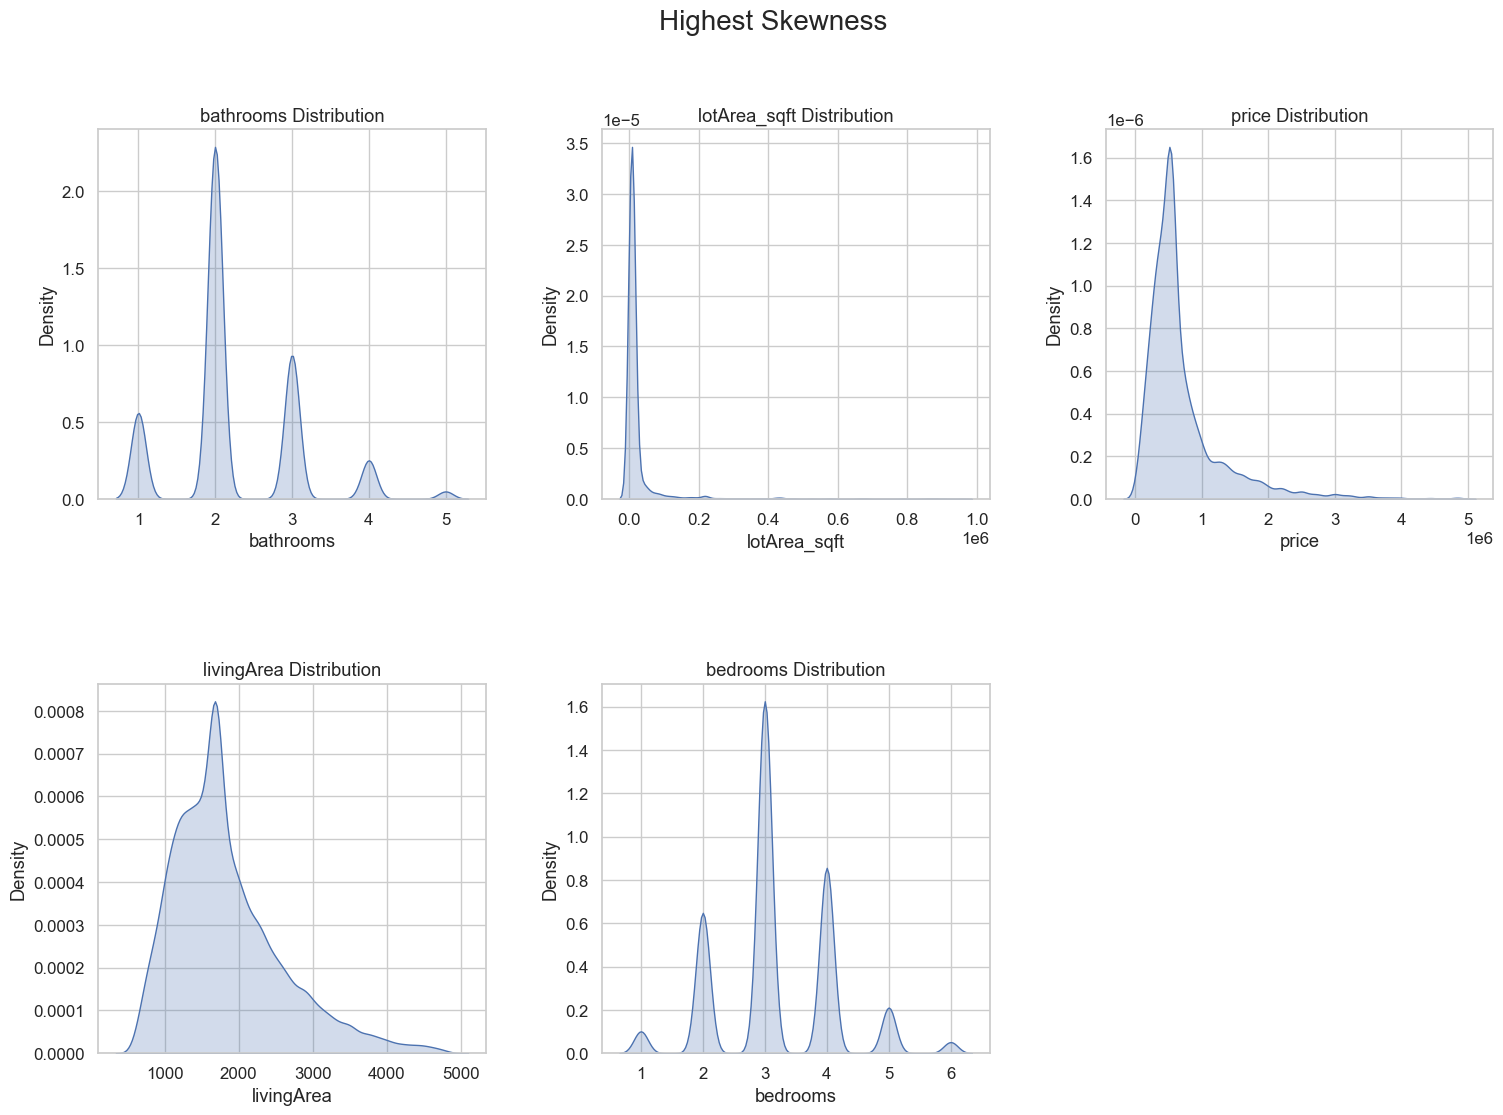

In [37]:
# Columns to visualize
cols = ['bathrooms', 'lotArea_sqft', 'price', 'livingArea', 'bedrooms']

# Setting the style
sns.set_style('whitegrid')

# Creating subplots: since there are 5 columns, we need a grid that can accommodate all of them
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjusted to fit all plots in a visually balanced way
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig.suptitle('Highest Skewness', fontsize=20)

# Looping over the columns and plotting
for i, col in enumerate(cols):
    sns.kdeplot(full_df[col], ax=axes[i//3][i%3], fill=True)
    axes[i//3][i%3].set_title(f'{col} Distribution')

# Turn off empty subplots
axes[1, 2].set_visible(False)

plt.show()

> ### Applying logarithmic transformations is an excellent strategy to reduce skewness, especially for positively skewed distributions commonly found in features like area, price. This transformation can help stabilize variance and make the data more normally distributed, which often improves the performance of many machine learning models.

### Normalizing and encoding the data

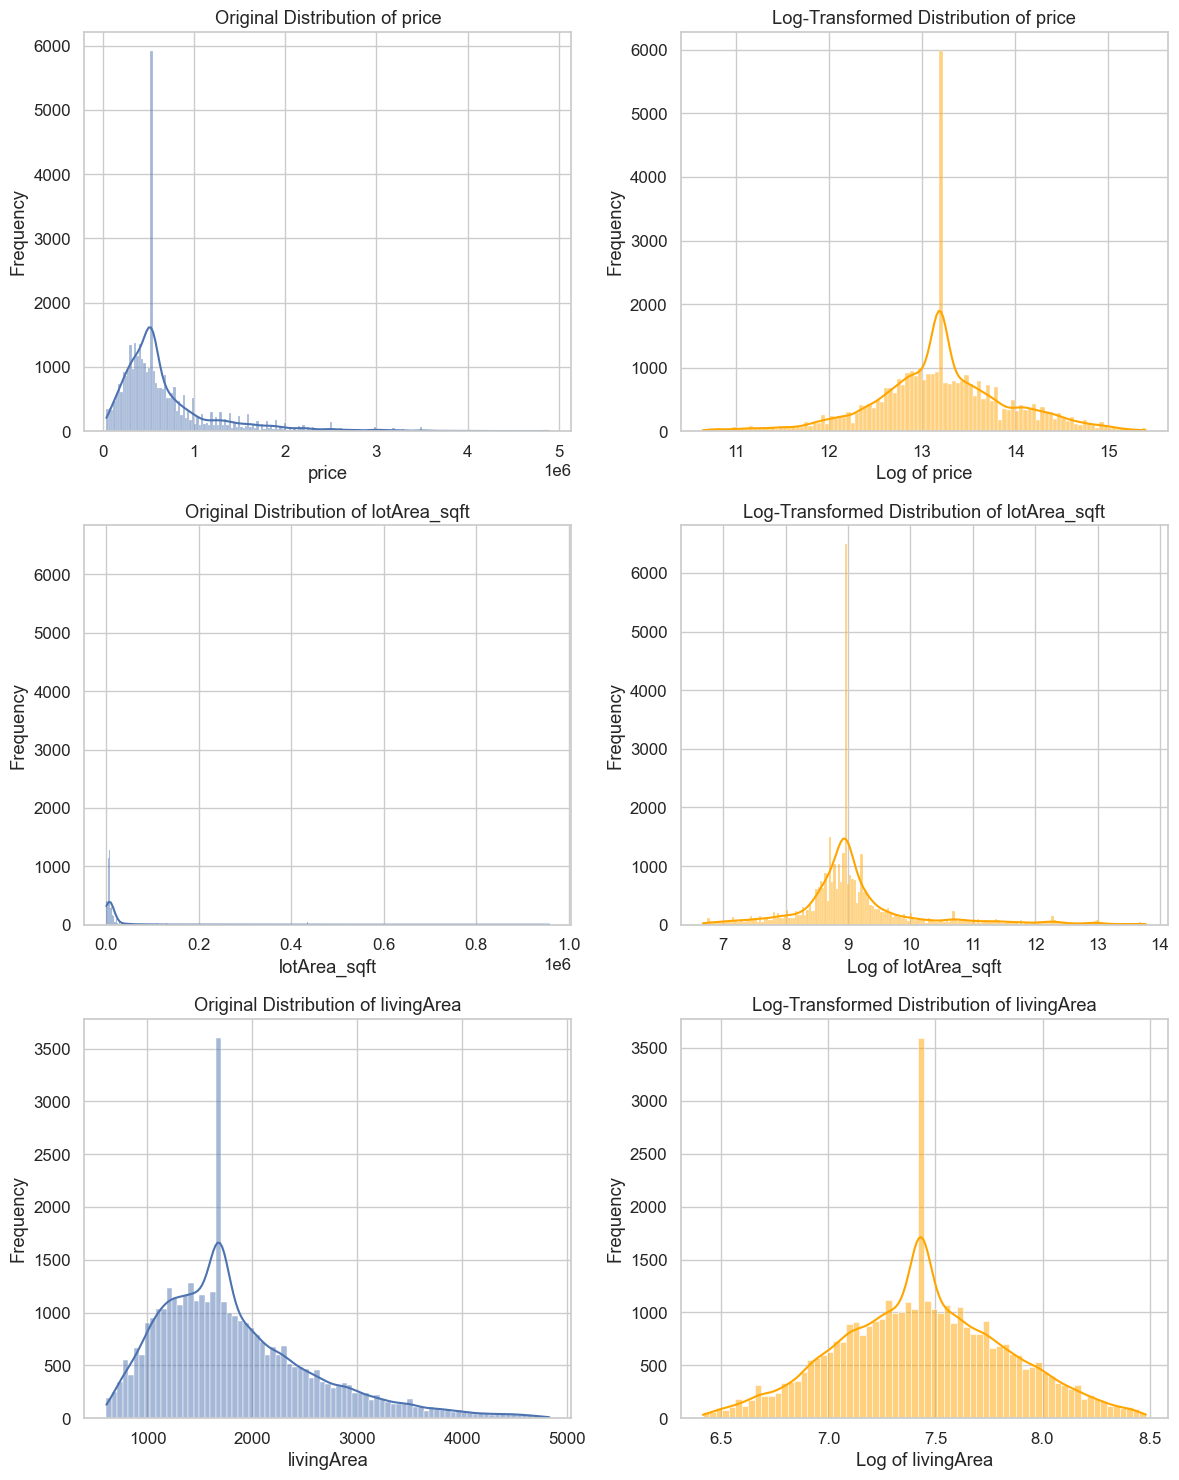

In [38]:
# Copying the original DataFrame to preserve the original data
df = full_df.copy()

# Applying logarithmic transformation to selected features to address skewness
df['log_price'] = np.log1p(df['price'])  # Log-transforming 'price'
df['log_lotArea_sqft'] = np.log1p(df['lotArea_sqft'])  # Log-transforming 'lotArea_sqft'
df['log_livingArea'] = np.log1p(df['livingArea'])  # Log-transforming 'livingArea'

# List of original and transformed columns for comparison
columns_to_check = ['price', 'lotArea_sqft', 'livingArea']
log_columns = ['log_price', 'log_lotArea_sqft', 'log_livingArea']

# Setting up the plot for visual comparison of distributions
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))
for i, col in enumerate(columns_to_check):
    # Plotting the original distribution
    sns.histplot(df[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Original Distribution of {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')

    # Plotting the log-transformed distribution
    sns.histplot(df[log_columns[i]], ax=axes[i, 1], kde=True, color='orange')
    axes[i, 1].set_title(f'Log-Transformed Distribution of {col}')
    axes[i, 1].set_xlabel('Log of ' + col)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
for col in cat_cols:
    # Create dummy variables for each category in the column
    dummies = pd.get_dummies(df[col], prefix=col, dtype=int)
    # Concatenate the dummy variables to the original DataFrame
    df = pd.concat([df, dummies], axis=1)
    # Optionally drop the original categorical column if no longer needed
    df.drop(col, axis=1, inplace=True)

In [40]:
df.to_csv('cleaned_data_for_ML_NOT_NORM.csv',index=False)

In [41]:

# Normalize numerical columns using logarithms to reduce skewness and handle large ranges of values
df[num_cols] = df[num_cols].apply(lambda x: np.log1p(x))


In [42]:
df.head()

,bathrooms,bedrooms,livingArea,price,lotArea_sqft,log_price,log_lotArea_sqft,log_livingArea,homeType_0,homeType_1,...,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17
0,1.098612,1.386294,7.515345,12.898972,8.832442,12.898972,8.832442,7.515345,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.098612,1.386294,7.358831,12.449023,11.077527,12.449023,11.077527,7.358831,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.098612,1.386294,7.723562,13.383190,11.519152,13.383190,11.519152,7.723562,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.098612,1.386294,7.430707,12.691584,12.856649,12.691584,12.856649,7.430707,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.609438,1.609438,8.063378,13.996999,10.682917,13.996999,10.682917,8.063378,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Get the number of rows and columns in the cleaned DataFrame
cleaned_rows, cleaned_columns = df.shape

# Print the dimensions of the cleaned DataFrame
print(f'After cleaning and with one hot encoding, the data contains {cleaned_rows} rows and {cleaned_columns} columns.')

After cleaning and with one hot encoding, the data contains 38888 rows and 38 columns.


In [44]:
df.to_csv('cleaned_data_for_ML.csv',index=False)